In [1]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

c:\Users\maart\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data into a pandas dataframe
merged_df = pd.read_csv('SP_SC.csv')

In [3]:
# Calculate the returns and log returns
merged_df['Returns'] = merged_df['Adj Close'].pct_change()
merged_df['Log_Returns'] = np.log(1 + merged_df['Returns'])

In [4]:
# Create a synthetic target variable by calculating the rolling standard deviation of log returns
merged_df['Volatility'] = merged_df['Log_Returns'].rolling(window=30).std() * np.sqrt(30)

In [5]:
# Drop the rows with missing values
merged_df.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [7]:
x_normalized = (merged_df['reg_output'] - np.min(merged_df['reg_output']) + 1) / (np.max(merged_df['reg_output']) - np.min(merged_df['reg_output']) + 1)

min(x_normalized)

0.5163319722955669

In [8]:
merged_df['reg_output_sc']= x_normalized

In [9]:
# Define the input and output variables
X = merged_df[['reg_output_sc']].values
y = merged_df['Log_Returns'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

In [12]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [13]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [22]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 1
hidden_size = 16
output_size = 1
num_epochs= 10
# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.001)

In [23]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (176, 1) (176,)
Testing Shape (45, 1) (45,)


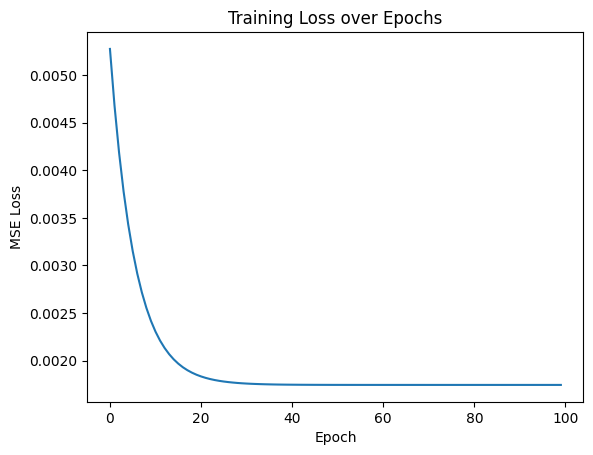

In [24]:
# Initializing Hyperparameters
num_epochs = 100
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [25]:
# Evaluate the LSTM model
mse = 0
#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.0014558649213533194


In [26]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)

    
for i, (data, label) in enumerate(train_loader):
    output_list.append(0)
    
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

In [27]:
dataY_plot = list(y)
data_predict = output_list

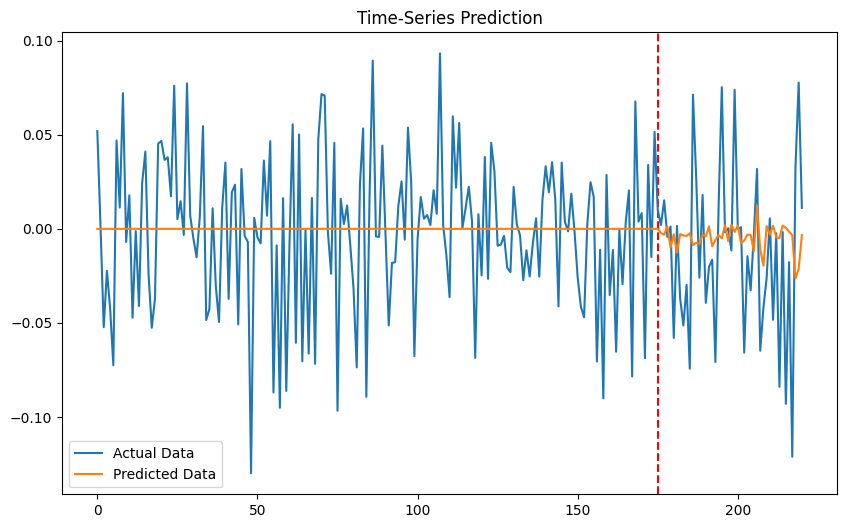

In [28]:

# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
# dataY_plot = y.Volume.values
data_predict = output_list

# data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=175, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [29]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>